In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import cv2
from PIL import Image
import scipy.io
import matplotlib.pyplot as plt

In [11]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001

In [12]:
TRAIN_IMAGE_DIR = '/kaggle/input/crowd-dataset-cnn/crowd_wala_dataset/train_data/images'
TRAIN_GT_DIR = '/kaggle/input/crowd-dataset-cnn/crowd_wala_dataset/train_data/ground_truth'
TEST_IMAGE_DIR = '/kaggle/input/crowd-dataset-cnn/crowd_wala_dataset/test_data/images'
TEST_GT_DIR = '/kaggle/input/crowd-dataset-cnn/crowd_wala_dataset/test_data/ground_truth'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} 🐧")

Using device: cuda 🐧


# Loading Dataset

In [14]:
class CustomCrowdDataset(Dataset):
    def __init__(self, img_folder_path, gt_folder_path, img_height, img_width, transform=None):
        self.img_folder_path = img_folder_path
        self.gt_folder_path = gt_folder_path
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        self.image_filenames = sorted([f for f in os.listdir(img_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.img_folder_path, img_filename)
        
        base_filename = os.path.splitext(img_filename)[0]
        gt_filename = f"GT_{base_filename}.mat"
        gt_path = os.path.join(self.gt_folder_path, gt_filename)

        if not os.path.exists(gt_path):
            print(f"Warning: GT not found for {img_filename} (expected {gt_path}). Skipping. 🧊")
            img = Image.new('RGB', (self.img_width, self.img_height), color = 'black')
            dummy_img = self.transform(img) if self.transform else transforms.ToTensor()(img)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((self.img_width, self.img_height)) 

            data = scipy.io.loadmat(gt_path)
            
            count = 0
            if 'image_info' in data and data['image_info'].size > 0:
                info_entry = data['image_info'][0,0] 
                
                try:
                    points_data = info_entry[0][0][0][0][0]
                    
                    if isinstance(points_data, np.ndarray):
                        if points_data.size > 0:
                            count = points_data.shape[0]
                        else:
                            count = 0 
                    elif isinstance(points_data, (int, float, np.int_, np.float_)):
                        count = float(points_data)
                    else:
                        print(f"Warning: Unexpected data type after deep access for {gt_filename}: {type(points_data)}. Setting count to 0")

                except (IndexError, KeyError, TypeError) as e:
                    print(f"Error accessing nested 'points' in 'image_info' for {gt_filename}: {e}.")
                    print(f"Please confirm the exact nested structure if not 'image_info[0,0][0][0][0][0]'.")
                    print("Setting count to 0.")
                    count = 0
            else:
                print(f"Warning: 'image_info' not found or is empty in {gt_filename}.")
                print(f"Available top-level keys in {gt_filename}: {data.keys()}")
                print("Setting count to 0.")
                count = 0
            
            if self.transform:
                img = self.transform(img)

            return img, torch.tensor(float(count), dtype=torch.float32)

        except Exception as e:
            print(f"Error processing {img_filename} or its GT: {e}. Returning dummy data. �")
            img = Image.new('RGB', (self.img_width, self.img_height), color = 'black')
            dummy_img = self.transform(img) if self.transform else transforms.ToTensor()(img)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)


In [15]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load Datasets ---
train_dataset = CustomCrowdDataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR, IMG_HEIGHT, IMG_WIDTH, transform=image_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = CustomCrowdDataset(TEST_IMAGE_DIR, TEST_GT_DIR, IMG_HEIGHT, IMG_WIDTH, transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")


Training set size: 400 images. 🎉
Test set size: 316 images. ✅


# CNN Architecture

In [16]:
class CrowdCountingCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(CrowdCountingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self._to_linear = 256 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16)

      
        self.regressor = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x


In [17]:
model = CrowdCountingCNN(input_channels=3).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

CrowdCountingCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(

In [18]:
train_losses = []
train_maes = []

print("\nTraining the model...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    for i, (images, counts) in enumerate(train_loader):
        images = images.to(device)
        counts = counts.to(device).float().view(-1, 1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, counts)
        mae = torch.abs(outputs - counts).mean()

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_mae += mae.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_mae = running_mae / len(train_dataset)
    train_losses.append(epoch_loss)
    train_maes.append(epoch_mae)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f}")

print("\nModel training complete!")



Training the model... 🎉
Epoch [1/50], Loss: 100436.8023, MAE: 221.9723
Epoch [2/50], Loss: 72940.8666, MAE: 212.5666
Epoch [3/50], Loss: 71954.0003, MAE: 206.8379
Epoch [4/50], Loss: 68815.1303, MAE: 205.7547
Epoch [5/50], Loss: 66140.5184, MAE: 202.0634
Epoch [6/50], Loss: 63740.3559, MAE: 197.1491
Epoch [7/50], Loss: 62807.4356, MAE: 197.6434
Epoch [8/50], Loss: 66391.6152, MAE: 197.5594
Epoch [9/50], Loss: 64904.1466, MAE: 197.8563
Epoch [10/50], Loss: 57543.8940, MAE: 187.2323
Epoch [11/50], Loss: 59754.9311, MAE: 192.3048
Epoch [12/50], Loss: 54105.5695, MAE: 179.2405
Epoch [13/50], Loss: 50752.9507, MAE: 178.6836
Epoch [14/50], Loss: 43545.4419, MAE: 162.2665
Epoch [15/50], Loss: 38823.5033, MAE: 157.4880
Epoch [16/50], Loss: 31648.9463, MAE: 138.7744
Epoch [17/50], Loss: 27004.4012, MAE: 130.5080
Epoch [18/50], Loss: 18149.1867, MAE: 104.6641
Epoch [19/50], Loss: 14990.6121, MAE: 93.1899
Epoch [20/50], Loss: 10826.2303, MAE: 78.3266
Epoch [21/50], Loss: 9871.6724, MAE: 75.4697


In [19]:
test_predictions = []
test_true_counts = []

if len(test_dataset) > 0:
    model.eval() 
    test_loss_sum = 0.0
    test_mae_sum = 0.0
    
    with torch.no_grad()
        for images, counts in test_loader:
            images = images.to(device)
            counts = counts.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, counts)
            mae = torch.abs(outputs - counts).mean()

            test_loss_sum += loss.item() * images.size(0)
            test_mae_sum += mae.item() * images.size(0)

            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_true_counts.extend(counts.cpu().numpy().flatten())

    final_test_loss = test_loss_sum / len(test_dataset)
    final_test_mae = test_mae_sum / len(test_dataset)
    print("\nEvaluating on test data...")
    print(f"Test Loss (MSE): {final_test_loss:.4f}")
    print(f"Test MAE: {final_test_mae:.4f}")


Evaluating on test data... 🔬
Test Loss (MSE): 58806.3257
Test MAE: 187.9335


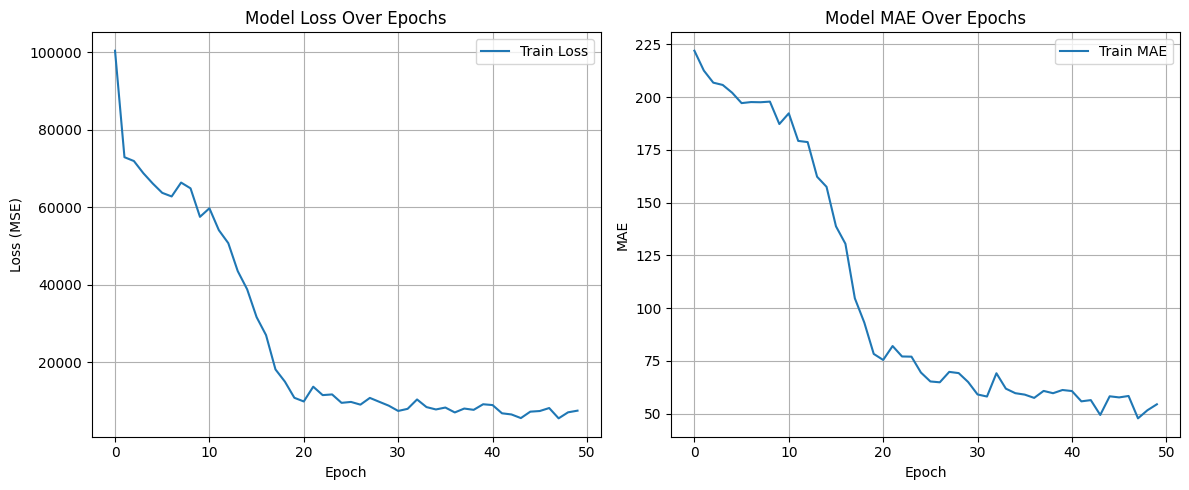

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
print(f"Image: {train_dataset.image_filenames[10]}, GT: GT_{os.path.splitext(train_dataset.image_filenames[10])[0]}.mat")

Image: IMG_108.jpg, GT: GT_IMG_108.mat



Displaying a sample test prediction.


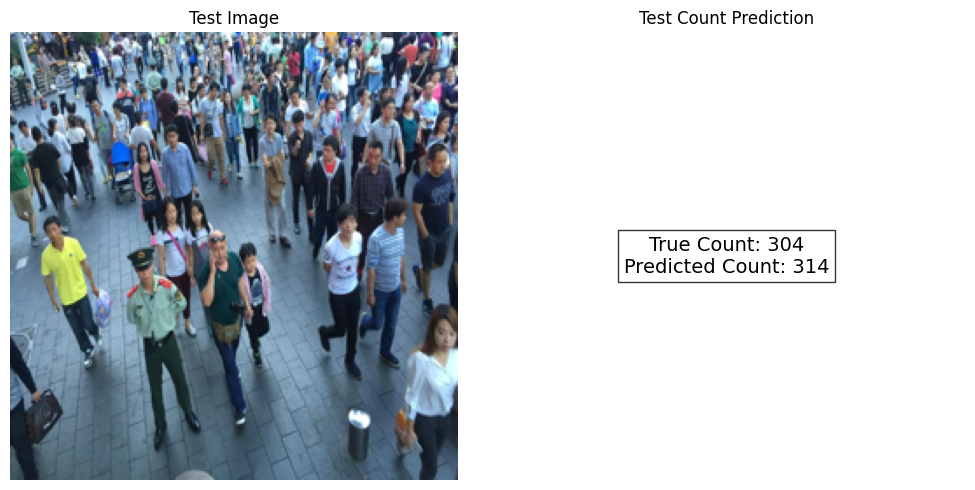

In [42]:
print("\nDisplaying a sample test prediction.")
if len(test_dataset) > 0:
    sample_index = 15
    sample_image_tensor, true_count = test_dataset[sample_index]

    sample_image_tensor = sample_image_tensor.unsqueeze(0).to(device) 
    
    model.eval()
    with torch.no_grad():
        predicted_count_tensor = model(sample_image_tensor)
        predicted_count = predicted_count_tensor.item() 
    original_img_path = os.path.join(test_dataset.img_folder_path, test_dataset.image_filenames[sample_index])
    original_img = Image.open(original_img_path).convert("RGB")
    original_img = original_img.resize((IMG_WIDTH, IMG_HEIGHT))


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f"True Count: {int(true_count)}\nPredicted Count: {int(round(predicted_count))}",
             fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.title('Test Count Prediction')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No test data available for sample prediction.")
